###                                  ISOC731 - Projet 

Nous avons un projet à réaliser pour ce module. Celui-ci porte sur les réseaux de graphes. C'est à dire que nous allons générer différents graphes puis les analyser.

###                                  Exercice 1 : 

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy.stats as st

n = 1000 # nombre de noeuds 

def make_graph(n): # fonction pour initialiser un graphe vide de n noeuds
    G = nx.Graph()
    for i in range(n):
        G.add_node(1)
    return G

def make_edges(G,p): # fonction pour ajouter des liens entre différents noeuds 
    """
    graph G : initial graph
    int p : probability of connexion between two nodes
    """
    for k in range(n):
        for node in list(G.nodes):
            # On vérifie qu'une probabilité uniforme est inférieure ou égale à notre probabilité seuil
            # De plus, on vérifie que les deux noeuds choisis ne sont pas les même
            if(rd.uniform(0.0, 1.0) <=p and node != k):
                G.add_edge(k,node)
    return G

# On initalise notre graphe vide
graph_global = make_graph(n)

100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


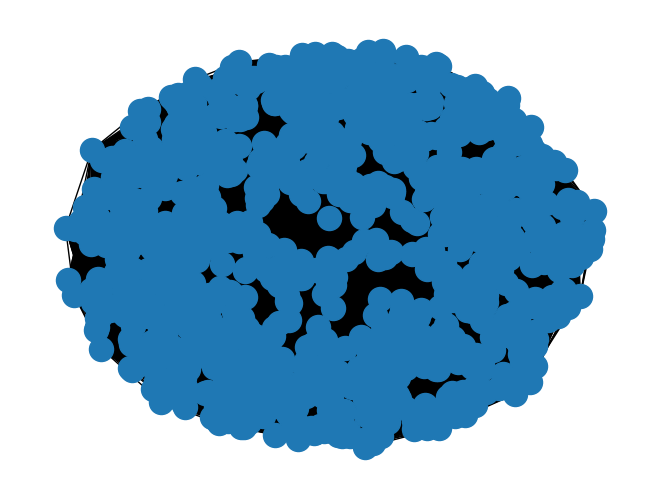

In [3]:
graphs = [] # Liste des différents graphes
probabilities = [] # Liste des probabilités

p = 0.01 # Probabilité minimale

# Nous parcourons pour 50 graphes
for i in tqdm(range(50)):
    # On crée les liens d'un nouveau graphe à partir de la copie du graphe précédemment créé
    graphs.append(make_edges(graph_global.copy(), p))
    probabilities.append(p)
    p += 0.01 # Pas de la probabilité

# Affiche le graphe avec la probabilité la plus haute
nx.draw(graphs[len(graphs)-1])

100%|██████████| 50/50 [00:00<00:00, 212.76it/s]


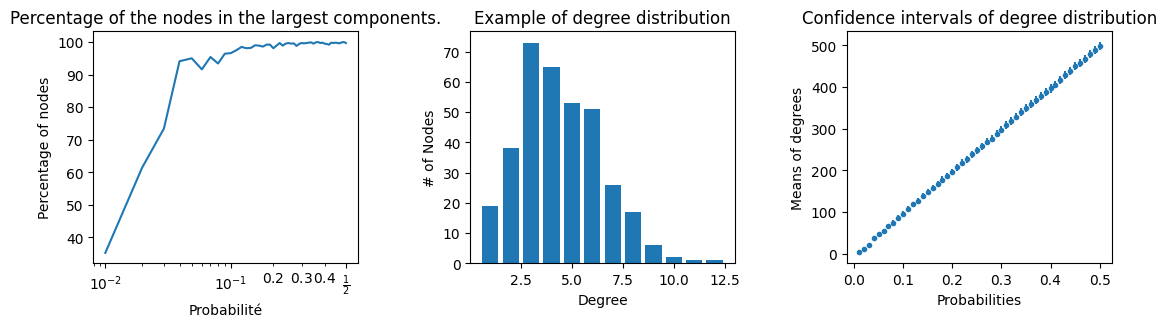

In [4]:
# On initialise nos tableaux
degree_distributions = []
largest_components = []
degrees = []

# On parcourt tous les graphes afin de récupérer leur dégré ainsi que le plus gros cluster
for g in tqdm(graphs):
    largest_components.append(len(max(nx.connected_components(g))) / n *100)
    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    degrees.append(degree_sequence)

# On créé un plan de 3 figures
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# Affiche le pourcentage des noeuds du plus gros cluster selon la probabilité
ax1.plot(probabilities, largest_components)
ax1.set_xscale("logit")
ax1.set_title("Percentage of the nodes in the largest components.")
ax1.set_xlabel("Probabilité")
ax1.set_ylabel("Percentage of nodes")

# Affiche un histogramme des dégrés du graphe avec la plus faible probabilité
ax2.bar(*np.unique(degrees[0], return_counts=True))
ax2.set_title("Example of degree distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")


means = []
intervals = []

# On parcourt les dégrés pour calculer l'interval d'erreur pour chaque valeur
for degree in degrees:
    intervals.append(st.t.interval(confidence=0.95,df=len(degree)-1,loc=np.mean(degree),scale=st.sem(degree)))
    means.append(np.mean(degree))

interval_dif_min = []
interval_dif_max = []

# Calcul de l'interval haut/bas
for i in range(len(means)):
    interval_dif_min.append((means[i] - intervals[i][0])*10)
    interval_dif_max.append((intervals[i][1] - means[i])*10)

y_error = [interval_dif_min,interval_dif_max]

# On affiche le nuage de points comprenant leur marge d'erreur
ax3.errorbar(probabilities,means,yerr = y_error,fmt='o',markersize = 3)
ax3.set_title("Confidence intervals of degree distribution")
ax3.set_xlabel("Probabilities")
ax3.set_ylabel("Means of degrees")
plt.show()

Cette première partie était centrée sur les graphes aléatoires. Nous obtenons alors 3 figures que nous retrouvons ci-dessus.

Le premier graphe est une courbe représentant le pourcentage des noeuds dans le plus grand cluster pour chaque probabilité. Nous remarquons alors que l'allure de la courbe se rapproche de la courbe de la fonction logarithmique. Nous observons qu'à partir d'environ 0,4 ; tous les noeuds du réseau sont connectés entre eux.

En outre, le second graphe montre un exemple de la distribution des degrés dans le réseau selon le nombre de noeuds. On remarque que l'allure du graphe est similaire à une loi normale. 

Enfin, le dernier graphe est un nuage de points présentant la moyenne des degrés de distribution ainsi que leur marge d'erreur. On discerne une courbe d'une fonction affine. La moyenne des degrés de distribution est alors proportionelle à la probabilité.

###                                  Exercice 2 :

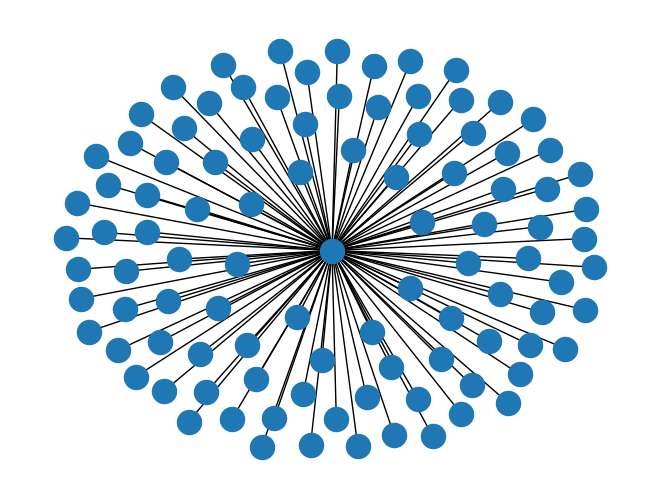

In [5]:
#2.1
G = nx.Graph()
n = 100
for i in range(n):
  G.add_node(i, value=0)

values = nx.get_node_attributes(G, 'value')
nodes = list(G.nodes)


def compute_value(node, values):
  new_value = 0
  if G.degree[node] == 1:
    new_value = 1
  elif G.degree[node] > 1:
    for neighbor in G.neighbors(node):
      new_value += values[neighbor]
  return new_value


# Ordre T aléatoire
rd.shuffle(nodes)

for node in nodes:
  # Dictionnaire des valeurs
  values = dict(sorted(values.items(), key=lambda item: item[1]))
  values.pop(node)

  # Valeur max qui optimise la valeur du noeud
  max_value = np.asarray(list(values.values())).max()
  
  # On cherche si il y a égalité
  max_values = [item for item in values.items() if item[1] == max_value]
  
  # Choix du noeud auquel se connecter
  node_to_connect = rd.choice(max_values)
 
  # Connection
  G.add_edge(node, node_to_connect[0])

  # Pour les deux nodes, on recalcule la valeur
  for node2 in [node, node_to_connect[0]]:
    new_value = compute_value(node2, values)
    values[node2] = new_value


  nx.set_node_attributes(G, values, "value")

#print(dict(sorted(values.items(), key=lambda item: item[0])))

nx.draw(G)

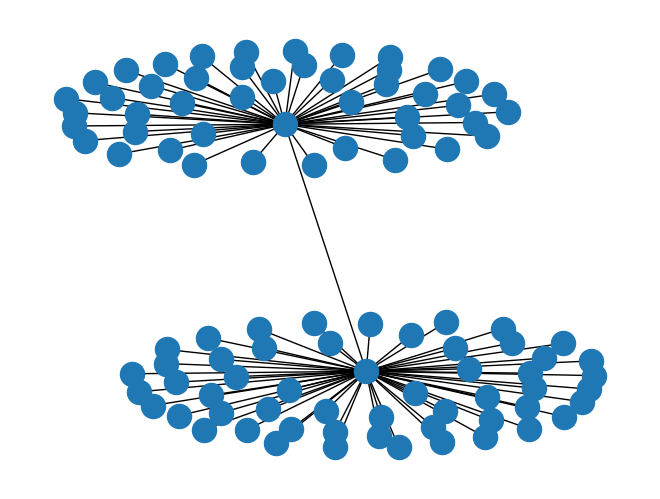

In [6]:
#2.2
G = nx.Graph()
n = 100
for i in range(n):
  G.add_node(i, value=0, karma=0)

values = nx.get_node_attributes(G, 'value')
nodes = list(G.nodes)

def compute_value(node, values):
  new_value = 0
  if G.degree[node] == 1:
    new_value = 1
  elif G.degree[node] > 1:
    for neighbor in G.neighbors(node):
      new_value += values[neighbor]
  return new_value


# Ordre T aléatoire
rd.shuffle(nodes)

for node in nodes:
  # Dictionnaire des valeurs
  values = dict(sorted(values.items(), key=lambda item: item[1]))
  values.pop(node)

  # 
  inferred_values = dict([item[0], rd.uniform(item[1]*0.1, item[1]*10)] for item in values.items())
  
  # Valeur max qui optimise la valeur du noeud
  max_value = np.asarray(list(inferred_values.values())).max()

  
  # On cherche si il y a égalité
  max_values = [item for item in inferred_values.items() if item[1] == max_value]

  
  # Choix du noeud auquel se connecter
  node_to_connect = rd.choice(max_values)
 
  # Connection
  G.add_edge(node, node_to_connect[0])

  # Pour les deux nodes, on recalcule la valeur
  for node2 in [node, node_to_connect[0]]:
    new_value = compute_value(node2, values)
    values[node2] = new_value

  nx.set_node_attributes(G, values, "value")

#print(dict(sorted(values.items(), key=lambda item: item[0])))

nx.draw(G)

### Exercice 3 :

node-> 68     bestToConnect()->5
node-> 27     bestToConnect()->39
node-> 21     bestToConnect()->78
node-> 0     bestToConnect()->34
node-> 4     bestToConnect()->65
node-> 33     bestToConnect()->14
node-> 53     bestToConnect()->28
node-> 85     bestToConnect()->9
node-> 78     bestToConnect()->60
node-> 76     bestToConnect()->51
node-> 80     bestToConnect()->34
node-> 58     bestToConnect()->36
node-> 82     bestToConnect()->52
node-> 62     bestToConnect()->52
node-> 8     bestToConnect()->46
node-> 98     bestToConnect()->9
node-> 74     bestToConnect()->49
node-> 78     bestToConnect()->42
node-> 64     bestToConnect()->63
node-> 43     bestToConnect()->49
node-> 71     bestToConnect()->66
node-> 13     bestToConnect()->92
node-> 84     bestToConnect()->45
node-> 19     bestToConnect()->35
node-> 39     bestToConnect()->15
node-> 98     bestToConnect()->38
node-> 70     bestToConnect()->65
node-> 27     bestToConnect()->26
node-> 64     bestToConnect()->89
node-> 36     bestTo

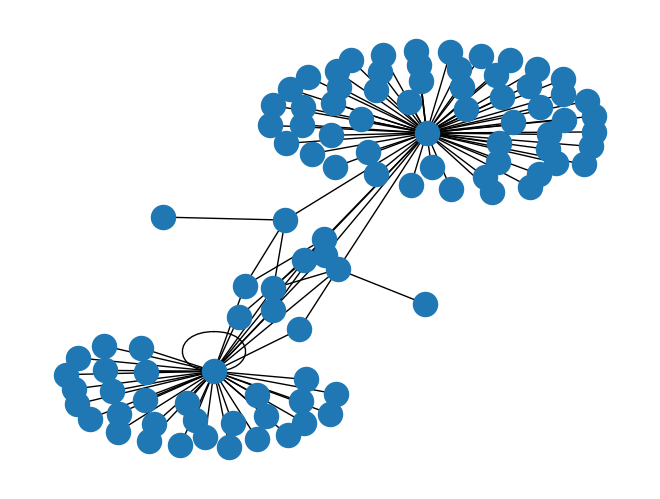

In [39]:
#3.1
graphs=[]
defectChances = 0.05
turns = 150
     

karmas = nx.get_node_attributes(G, 'karma')
def bestToConnect():
    res=[]
    for key,val in karmas.items():
        if val == min(karmas.values()):
            res.append(key)
    return res[rd.randint(0,len(res)-1)]


for turn in range(1,turns):
    for node in nodes:
        if rd.random() <= defectChances:
            rdmNeighbor=list(nx.all_neighbors(G,node))[rd.randint(0,len(list(nx.neighbors(G,node)))-1)]
            G.remove_edge(node,rdmNeighbor)
            karmas[node]=((karmas[node]*turn-1)+1)/turn
            print("node-> "+str(node)+"     bestToConnect()->"+str(bestToConnect()))
            G.add_edge(node,bestToConnect())
            if len(list(nx.all_neighbors(G,rdmNeighbor)))==0:
                G.add_edge(rdmNeighbor,bestToConnect())

        else:
            karmas[node]=(karmas[node]*turn-1)/turn
    graphs.append(G.copy())

        
nx.draw(G)


Avec l'ajout du Karma on remarque que la modélisation tend vers une forme centré sur un seul point lorsque le nombre de tours est trop élevé, et cela même si plusieurs clusters pouvaient être distingués lors de l'étape précédente.

100%|██████████| 149/149 [00:00<00:00, 8751.35it/s]


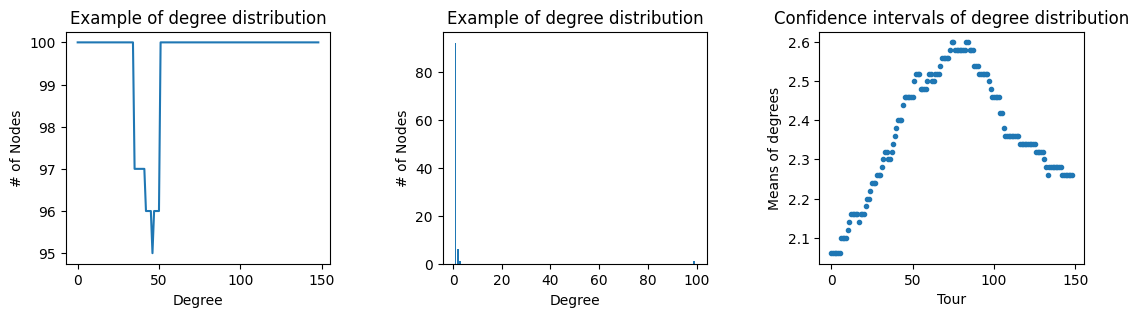

In [48]:
# On initialise nos tableaux
largest_components = []
turns=[]
degrees = []
for i in range(len(graphs)):
    turns.append(i)

# On parcourt tous les graphes afin de récupérer leur dégré ainsi que le plus gros cluster
for g in tqdm(graphs):
    largest_components.append(len(max(nx.connected_components(g))))
    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    degrees.append(degree_sequence)

# On créé un plan de 3 figures
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# Affiche le pourcentage des noeuds du plus gros cluster selon la probabilité
ax2.bar(*np.unique(degrees[0], return_counts=True))
ax2.set_title("Example of degree distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")


# Affiche un histogramme des dégrés du graphe avec la plus faible probabilité
ax1.plot(turns,largest_components )
ax1.set_title("Example of degree distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of Nodes")

means = []
intervals = []

# On parcourt les dégrés pour calculer l'interval d'erreur pour chaque valeur
for degree in degrees:
    intervals.append(st.t.interval(confidence=0.95,df=len(degree)-1,loc=np.mean(degree),scale=st.sem(degree)))
    means.append(np.mean(degree))

interval_dif_min = []
interval_dif_max = []

# Calcul de l'interval haut/bas
for i in range(len(means)):
    interval_dif_min.append((means[i] - intervals[i][0])*10)
    interval_dif_max.append((intervals[i][1] - means[i])*10)

y_error = [interval_dif_min,interval_dif_max]

# On affiche le nuage de points comprenant leur marge d'erreur
ax3.errorbar(list(range(turn)),means,fmt='o',markersize = 3)
ax3.set_title("Final degree distribution")
ax3.set_xlabel("Tour")
ax3.set_ylabel("Means of degrees")



plt.show()